centroids: [0] age, [1] ctroidx, [2] ctroidy, [3] area, [4] distance, [5] reltime

In [1]:

import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
import os
import scipy.stats as st
import seaborn as sns
import math 
import matplotlib.animation as animation
import matplotlib.colors as mcol
import matplotlib.cm as cm
import time
import random
import statistics as stat
import statsmodels.api as sm 
import pylab as py
import warnings
import scipy.stats as stats

from xml.dom import minidom
from shapely.geometry import Polygon, MultiPolygon
from descartes import PolygonPatch
from PIL import Image
from scipy.spatial import distance
from scipy import signal
from scipy import interpolate
from scipy.stats import variation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from celluloid import Camera

#plt.style.use('seaborn-white')

from matplotlib.collections import LineCollection, PatchCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

%matplotlib inline
#%matplotlib qt

In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

In [2]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 10}

mpl.rc('font', **font)

In [3]:

def choose_subplot_dimensions(k):
    if k < 4:
        return k, 1
    elif k < 11:
        return math.ceil(k/2), 2
    else:
        # I've chosen to have a maximum of 3 columns
        return math.ceil(k/5), 5


def generate_subplots(k, row_wise=False):
    nrow, ncol = choose_subplot_dimensions(k)
    # Choose your share X and share Y parameters as you wish:
    figure, axes = plt.subplots(nrow, ncol,
                                sharex=True,
                                sharey=False, figsize = (sz))

    # Check if it's an array. If there's only one plot, it's just an Axes obj
    if not isinstance(axes, np.ndarray):
        return figure, [axes]
    else:
        # Choose the traversal you'd like: 'F' is col-wise, 'C' is row-wise
        axes = axes.flatten(order=('C' if row_wise else 'F'))

        # Delete any unused axes from the figure, so that they don't show
        # blank x- and y-axis lines
        for idx, ax in enumerate(axes[k:]):
            figure.delaxes(ax)

            # Turn ticks on for the last ax in each column, wherever it lands
            idx_to_turn_on_ticks = idx + k - ncol if row_wise else idx + k - 1
            for tk in axes[idx_to_turn_on_ticks].get_xticklabels():
                tk.set_visible(True)

        axes = axes[:k]
        return figure, axes

In [4]:
# source: https://stackoverflow.com/questions/23461713/obtaining-values-used-in-boxplot-using-python-and-matplotlib

def reverse_colourmap(cmap, name = 'my_cmap_r'):
    reverse = []
    k = []   

    for key in cmap._segmentdata:    
        k.append(key)
        channel = cmap._segmentdata[key]
        data = []

        for t in channel:                    
            data.append((1-t[0],t[2],t[1]))            
        reverse.append(sorted(data))    

    LinearL = dict(zip(k,reverse))
    my_cmap_r = mpl.colors.LinearSegmentedColormap(name, LinearL) 
    return my_cmap_r

In [5]:
def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['mean'] = bp['means'][i].get_ydata()[1]
        dict1['fliers'] = bp['fliers'][i].get_ydata()
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

In [1]:
from os import listdir
from os.path import isfile, join
idf = '2h400'
nickname = 'agubh2'
folder = f'mc-{idf}-{nickname}'
mypath = '/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/nparrays/centroids_mainsurfs/'+folder
savefilesto = '/Volumes/SAF_MSCWORK/Python/Stratigraphy/Plots/bwcompare/'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles = sorted(onlyfiles)
print(onlyfiles)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/nparrays/centroids_mainsurfs/mc-2h400-agubh2'

In [7]:
cm1 = 'Reds'
cnorm = mcol.Normalize(vmin=0,vmax=len(onlyfiles))

# Turn these into an object that can be used to map time values to colors and can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap='tab20c') 
cpick.set_array([])

In [8]:
datamaster = {}
ages = {}
centx = {}
centy = {}
areas = {}
distances = {}
minx = {}
miny = {}
maxx = {}
maxy = {}
widths = {}
heights = {}
reltime = {}
delx = {}
dely = {}
whr = {}
angle = {}

indices = []
for i in onlyfiles:
    keynm = str(i)
    #print(keynm)
    #print(i)
    i = np.load('/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/nparrays/centroids_mainsurfs/'+folder+'/'+i, allow_pickle = True)
    #print(i.shape)
    ages[keynm] = i[:,0]
    centx[keynm] = i[:, 1]
    centy[keynm] = i[:, 2]
    areas[keynm] = i[:, 3]
    distances[keynm] = i[:, 10]
    minx[keynm] = i[:, 4]
    miny[keynm] = i[:, 5]
    maxx[keynm] = i[:, 6]
    maxy[keynm] = i[:, 7]
    reltime[keynm] = i[:, 11]
    widths[keynm] = i[:, 8]
    heights[keynm] = i[:, 9]
    delx[keynm] = i[:, 12]
    dely[keynm] = i[:, 13]
    whr[keynm] = i[:, 12]/i[:, 13]
    angle[keynm] = np.degrees(np.arctan(abs(abs(i[1:, 5]-i[1:, 7])-abs(i[:-1, 5]-i[:-1, 7]))/abs(abs(i[1:, 6]-i[1:, 4])-abs(i[:-1, 6]-i[:-1, 4]))))

    
for i in onlyfiles:
    keynm = str(i)
    datamaster[keynm] = np.load('/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/nparrays/centroids_mainsurfs/'+folder+'/'+i)
    whra = np.reshape(np.divide(datamaster[keynm][:, 12], datamaster[keynm][:, 13]), [len(datamaster[keynm][:, 9]), 1])
    ang = np.degrees(np.arctan(abs(abs(datamaster[keynm][1:, 5]-datamaster[keynm][1:, 7])-abs(datamaster[keynm][:-1, 5]-datamaster[keynm][:-1, 7]))/abs(abs(datamaster[keynm][1:, 6]-datamaster[keynm][1:, 4])-abs(datamaster[keynm][:-1, 6]-datamaster[keynm][:-1, 4]))))
    ang = np.append(0, ang)
    ang = np.reshape(ang, [len(datamaster[keynm][:, 9]), 1])
    datamaster[keynm] = np.concatenate((datamaster[keynm], whra, ang), axis = 1)
    #print(datamaster['c100'][:, 10]) ##how you access things in the arrayas


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide


<Figure size 432x288 with 0 Axes>

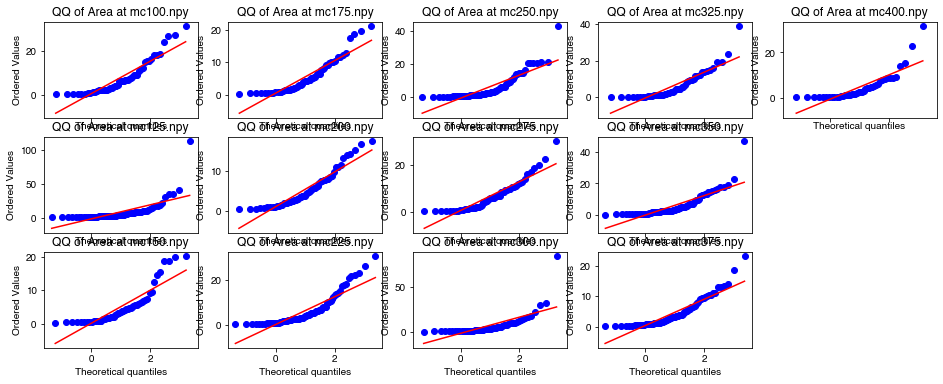

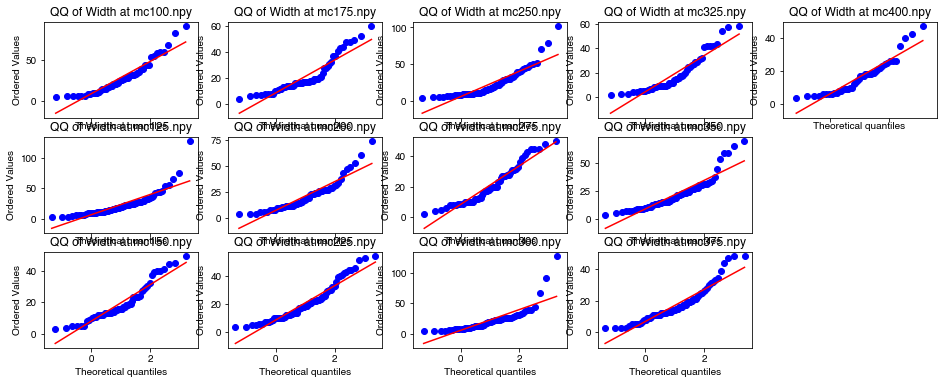

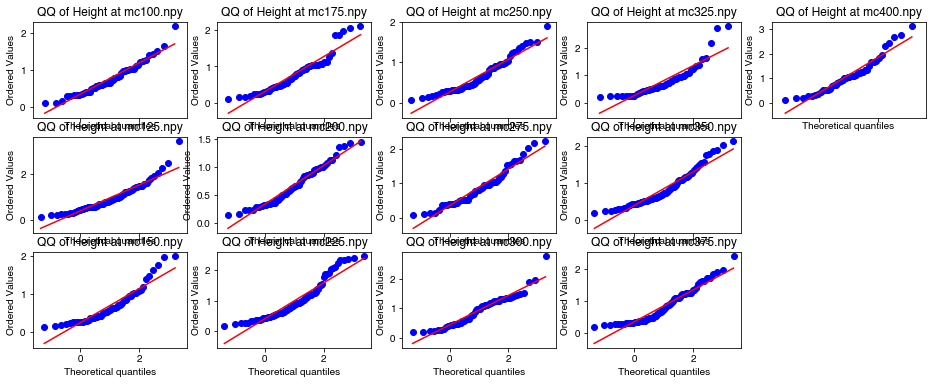

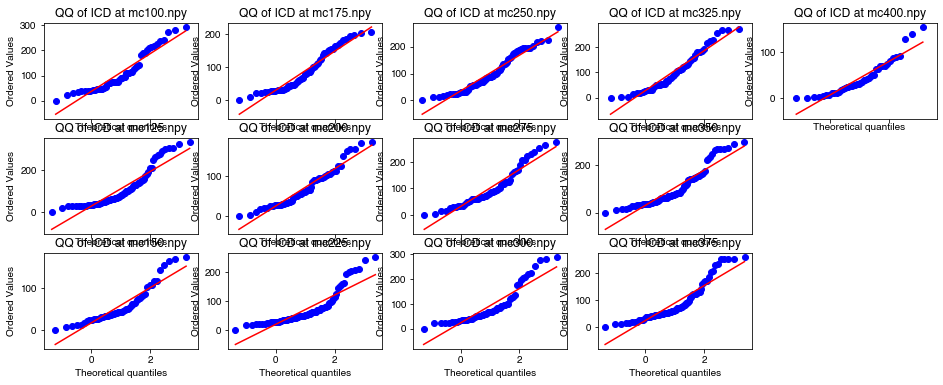

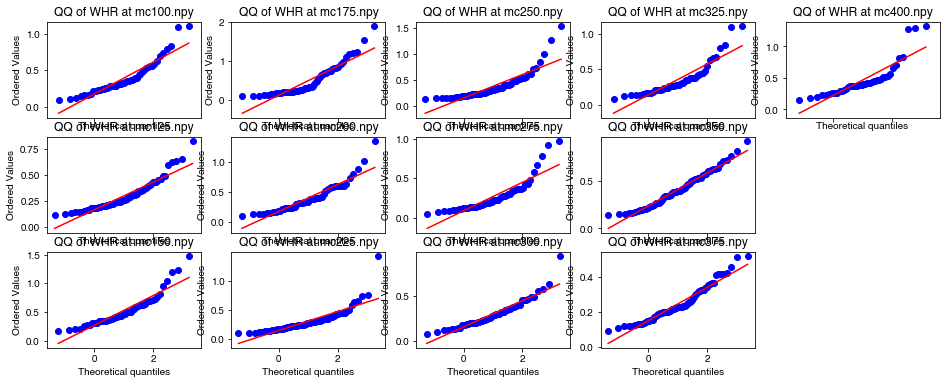

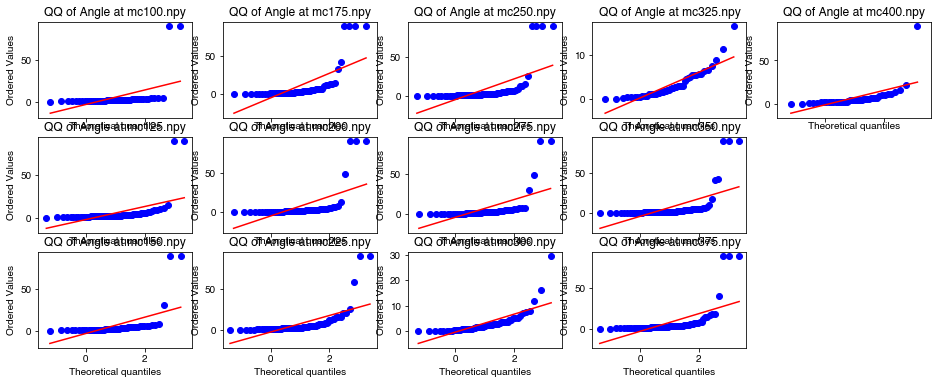

In [23]:
desiredcols = [3, 8, 9, 10, 14, 15]
labels = ['Area', 'Width', 'Height', 'ICD', 'WHR', 'Angle']
sz = (16, 6)
#fig, ax = plt.subplots(4, 3, figsize = (15, 10), tight_layout = True)
for i, d in enumerate(desiredcols): #plot QQ for each data type

    plt.figure(i, tight_layout = True)
    fig, ax = generate_subplots(13)
    ax = ax.ravel()
    for idx, keynm in enumerate(onlyfiles):
        qq, qqdat = scipy.stats.probplot(datamaster[keynm][:, d], dist=stats.norm, sparams=(1,), plot=ax[idx])
        ax[idx].set_title(f'QQ of {labels[i]} at {keynm}')
        #print(qqdat)

age, cent x (1), cent y (2), cent area (3), pol minx (4), pol miny (5), pol maxx (6), pol maxy (7), pol width (8), pol height (9), distance (10), reltime (11), delx (12), dely (13)

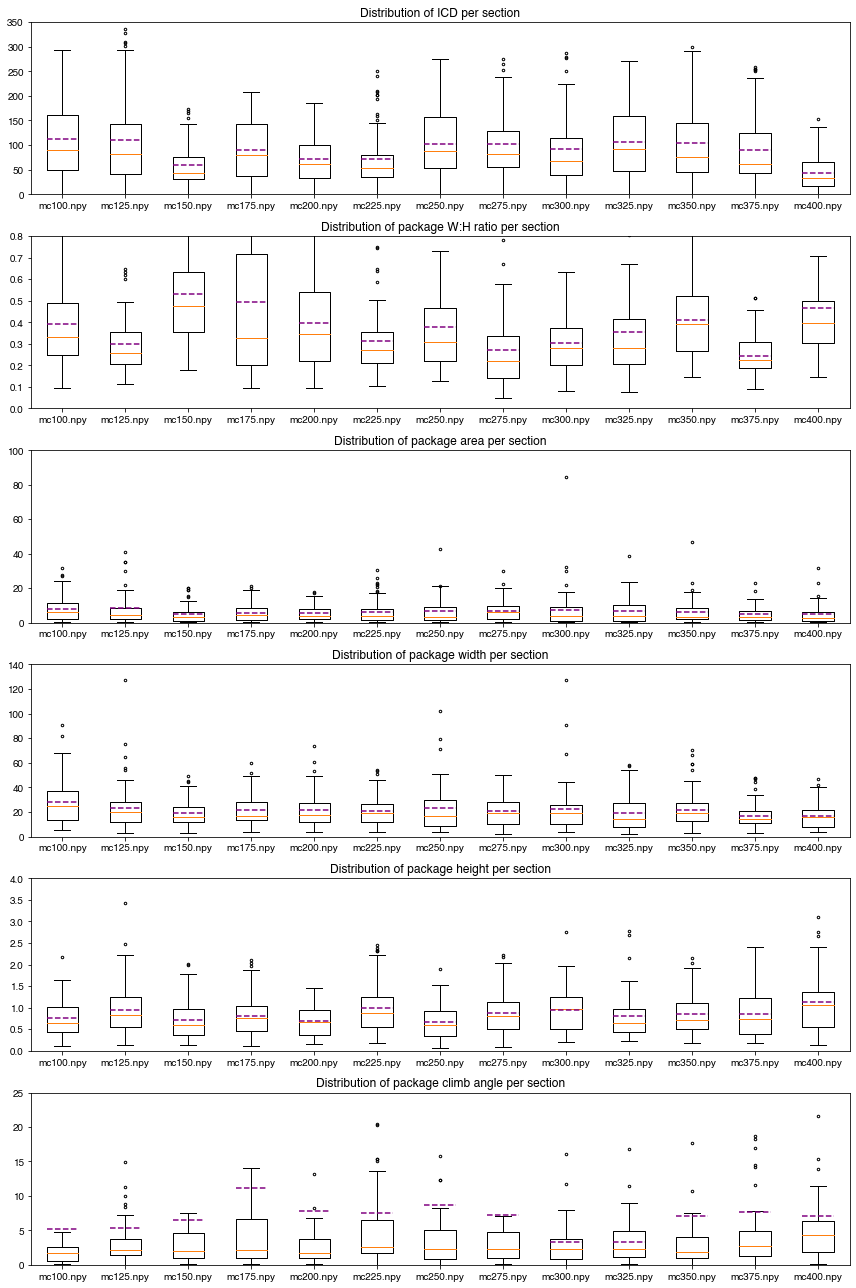

In [11]:
fig, ax = plt.subplots(6, 1, figsize = (12,18), tight_layout=True)

meanlineprops = dict(linestyle='--', linewidth=1.5, color='purple')
flierprops= dict(marker='.', ms=5)

## meaningful statistics might be ICD, dely (aggradation indicator?), area, wdiths, heights, w:h 

icdist = ax[0].boxplot(distances.values(), vert = True, showfliers = True, meanline = True, meanprops = meanlineprops, showmeans = True, flierprops=flierprops)
w_to_h = ax[1].boxplot(whr.values(), vert = True, showfliers = True, meanline = True, meanprops = meanlineprops, showmeans = True, flierprops=flierprops)
centarea = ax[2].boxplot(areas.values(), vert = True, showfliers = True, meanline = True, meanprops = meanlineprops, showmeans = True, flierprops=flierprops)
polwidth = ax[3].boxplot(widths.values(), vert = True, showfliers = True, meanline = True, meanprops = meanlineprops, showmeans = True, flierprops=flierprops)
polheight = ax[4].boxplot(heights.values(), vert = True, showfliers = True, meanline = True, meanprops = meanlineprops, showmeans = True, flierprops=flierprops)
climb = ax[5].boxplot(angle.values(), vert= True, showfliers = True, meanline = True, meanprops = meanlineprops, showmeans = True, flierprops=flierprops)


ax[0].set_xticks(np.arange(1, len(onlyfiles)+1))
ax[0].set_xticklabels(onlyfiles)

ax[1].set_xticks(np.arange(1, len(onlyfiles)+1))
ax[1].set_xticklabels(onlyfiles)

ax[2].set_xticks(np.arange(1, len(onlyfiles)+1))
ax[2].set_xticklabels(onlyfiles)

ax[3].set_xticks(np.arange(1, len(onlyfiles)+1))
ax[3].set_xticklabels(onlyfiles)

ax[4].set_xticks(np.arange(1, len(onlyfiles)+1))
ax[4].set_xticklabels(onlyfiles)

ax[5].set_xticks(np.arange(1, len(onlyfiles)+1))
ax[5].set_xticklabels(onlyfiles)

ax[0].set_title('Distribution of ICD per section')
ax[1].set_title('Distribution of package W:H ratio per section')
ax[2].set_title('Distribution of package area per section')
ax[3].set_title('Distribution of package width per section')
ax[4].set_title('Distribution of package height per section')
ax[5].set_title('Distribution of package climb angle per section')

ax[0].set_ylim(0, 350)
ax[1].set_ylim(0, 0.8)
ax[2].set_ylim(0, 100)
ax[3].set_ylim(0, 140)
ax[4].set_ylim(0, 4)
ax[5].set_ylim(0, 25)
plt.savefig(f'{savefilesto}bw{folder}.png', dpi = 100)

In [12]:
icdstats = get_box_plot_data(onlyfiles, icdist)
whstats = get_box_plot_data(onlyfiles, w_to_h)
areastats = get_box_plot_data(onlyfiles, centarea)
widthstats = get_box_plot_data(onlyfiles, polwidth)
heightstats = get_box_plot_data(onlyfiles, polheight)
anglestats = get_box_plot_data(onlyfiles, climb)

In [13]:
stds = np.empty([13, 6]) #last columns are the range of data
for keynm, i in zip(onlyfiles, range(0, 13)):
    stds[i, 0] = np.std(datamaster[keynm][:, 10])
    stds[i, 1] = np.std(datamaster[keynm][:, 8])
    stds[i, 2] = np.std(datamaster[keynm][:, 9])
    stds[i, 3] = np.std(datamaster[keynm][:, 13])

In [14]:
#create array
area_anova = stats.f_oneway(datamaster['mc100.npy'][:, 3], 
                            datamaster['mc125.npy'][:, 3],
                            datamaster['mc150.npy'][:, 3],
                            datamaster['mc175.npy'][:, 3],
                            datamaster['mc200.npy'][:, 3], 
                            datamaster['mc225.npy'][:, 3],
                            datamaster['mc250.npy'][:, 3],
                            datamaster['mc275.npy'][:, 3],
                            datamaster['mc300.npy'][:, 3], 
                            datamaster['mc325.npy'][:, 3],
                            datamaster['mc350.npy'][:, 3],
                            datamaster['mc375.npy'][:, 3],
                            datamaster['mc400.npy'][:, 3])

wh_anova = stats.f_oneway(datamaster['mc100.npy'][:, 14], 
                            datamaster['mc125.npy'][:, 14],
                            datamaster['mc150.npy'][:, 14],
                            datamaster['mc175.npy'][:, 14],
                            datamaster['mc200.npy'][:, 14], 
                            datamaster['mc225.npy'][:, 14],
                            datamaster['mc250.npy'][:, 14],
                            datamaster['mc275.npy'][:, 14],
                            datamaster['mc300.npy'][:, 14], 
                            datamaster['mc325.npy'][:, 14],
                            datamaster['mc350.npy'][:, 14],
                            datamaster['mc375.npy'][:, 14],
                            datamaster['mc400.npy'][:, 14])

w_anova = stats.f_oneway(datamaster['mc100.npy'][:, 8], 
                            datamaster['mc125.npy'][:, 8],
                            datamaster['mc150.npy'][:, 8],
                            datamaster['mc175.npy'][:, 8],
                            datamaster['mc200.npy'][:, 8], 
                            datamaster['mc225.npy'][:, 8],
                            datamaster['mc250.npy'][:, 8],
                            datamaster['mc275.npy'][:, 8],
                            datamaster['mc300.npy'][:, 8], 
                            datamaster['mc325.npy'][:, 8],
                            datamaster['mc350.npy'][:, 8],
                            datamaster['mc375.npy'][:, 8],
                            datamaster['mc400.npy'][:, 8])
h_anova = stats.f_oneway(datamaster['mc100.npy'][:, 9], 
                            datamaster['mc125.npy'][:, 9],
                            datamaster['mc150.npy'][:, 9],
                            datamaster['mc175.npy'][:, 9],
                            datamaster['mc200.npy'][:, 9], 
                            datamaster['mc225.npy'][:, 9],
                            datamaster['mc250.npy'][:, 9],
                            datamaster['mc275.npy'][:, 9],
                            datamaster['mc300.npy'][:, 9], 
                            datamaster['mc325.npy'][:, 9],
                            datamaster['mc350.npy'][:, 9],
                            datamaster['mc375.npy'][:, 9],
                            datamaster['mc400.npy'][:, 9])
icd_anova = stats.f_oneway(datamaster['mc100.npy'][:, 10], 
                            datamaster['mc125.npy'][:, 10],
                            datamaster['mc150.npy'][:, 10],
                            datamaster['mc175.npy'][:, 10],
                            datamaster['mc200.npy'][:, 10], 
                            datamaster['mc225.npy'][:, 10],
                            datamaster['mc250.npy'][:, 10],
                            datamaster['mc275.npy'][:, 10],
                            datamaster['mc300.npy'][:, 10], 
                            datamaster['mc325.npy'][:, 10],
                            datamaster['mc350.npy'][:, 10],
                            datamaster['mc375.npy'][:, 10],
                            datamaster['mc400.npy'][:, 10])
angle_anova = stats.f_oneway(datamaster['mc100.npy'][:, 15], 
                            datamaster['mc125.npy'][:, 15],
                            datamaster['mc150.npy'][:, 15],
                            datamaster['mc175.npy'][:, 15],
                            datamaster['mc200.npy'][:, 15], 
                            datamaster['mc225.npy'][:, 15],
                            datamaster['mc250.npy'][:, 15],
                            datamaster['mc275.npy'][:, 15],
                            datamaster['mc300.npy'][:, 15], 
                            datamaster['mc325.npy'][:, 15],
                            datamaster['mc350.npy'][:, 15],
                            datamaster['mc375.npy'][:, 15],
                            datamaster['mc400.npy'][:, 15])

print('ANOVA for area: ', area_anova)
print('ANOVA for W:H: ', wh_anova)
print('ANOVA for Width: ', w_anova)
print('ANOVA for Height: ', h_anova)
print('ANOVA for ICD: ', icd_anova)
print('ANOVA for Climb Angle: ', angle_anova)

ANOVA for area:  F_onewayResult(statistic=1.2595086907478543, pvalue=0.2378803060450112)
ANOVA for W:H:  F_onewayResult(statistic=9.275863349325421, pvalue=6.551036903792314e-17)
ANOVA for Width:  F_onewayResult(statistic=2.137702920621732, pvalue=0.013029962734321875)
ANOVA for Height:  F_onewayResult(statistic=3.6663671264386486, pvalue=2.1916466993982365e-05)
ANOVA for ICD:  F_onewayResult(statistic=5.475757479422278, pvalue=5.163242282844325e-09)
ANOVA for Climb Angle:  F_onewayResult(statistic=0.8642537852634365, pvalue=0.5836593059151278)


In [15]:
statsgroup = ['icdstats', 'widthstats', 'heightstats', 'whstats']

for i in statsgroup:
    print(i)

icdstats
widthstats
heightstats
whstats


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


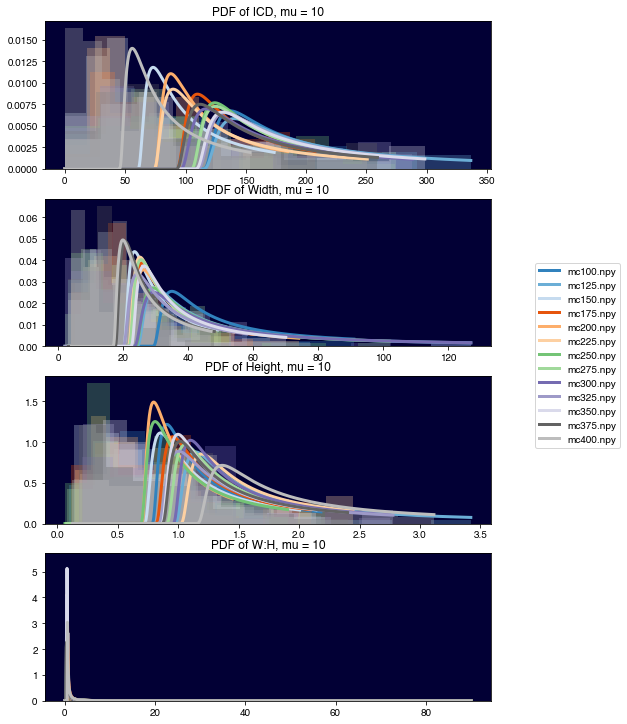

<Figure size 432x288 with 0 Axes>

In [16]:
fig, ax = plt.subplots(4, figsize = (8, 12.5), tight_layout = True)
lines=[]

for i in range (0, 13):
    mu = 10
    icdmean = icdstats['mean'][i]
    widthmean = widthstats['mean'][i]
    heightmean = heightstats['mean'][i]
    whmean = whstats['mean'][i]
    
    icdstd = stds[i, 0]
    widthstd = stds[i, 1]
    heightstd = stds[i, 2]
    whstd = stds[i, 3]
    
    #icdx = np.linspace(icdstats['upper_whisker'][i], icdstats['lower_whisker'][i], 1000)
    #widthx = np.linspace(widthstats['upper_whisker'][i], widthstats['lower_whisker'][i], 1000)
    #heightx = np.linspace(heightstats['upper_whisker'][i], heightstats['lower_whisker'][i], 1000)
    #whx = np.linspace(whstats['upper_whisker'][i], whstats['lower_whisker'][i], 1000)
    
    icdx = np.linspace(datamaster[onlyfiles[i]][:, 10].min(), datamaster[onlyfiles[i]][:, 10].max(), 1000)
    widthx = np.linspace(datamaster[onlyfiles[i]][:, 8].min(), datamaster[onlyfiles[i]][:, 8].max(), 1000)
    heightx = np.linspace(datamaster[onlyfiles[i]][:, 9].min(), datamaster[onlyfiles[i]][:, 9].max(), 1000)
    whx = np.linspace(datamaster[onlyfiles[i]][:, -1].min(), datamaster[onlyfiles[i]][:, -1].max(), 1000)
    
    ax[0].hist(distances[onlyfiles[i]], density = True, alpha = 0.3, color = cpick.to_rgba(i))
    ax[1].hist(widths[onlyfiles[i]], density = True, alpha = 0.3, color = cpick.to_rgba(i))
    ax[2].hist(heights[onlyfiles[i]], density = True, alpha = 0.3, color = cpick.to_rgba(i))
    ax[3].hist(whr[onlyfiles[i]], density = True, alpha = 0.3, color = cpick.to_rgba(i))
    
    lines += ax[0].plot(icdx, stats.invgauss.pdf(x = icdx, mu =mu, loc = icdmean, scale = icdstd), label = onlyfiles[i], color = cpick.to_rgba(i), lw = 3)
    ax[1].plot(widthx, stats.invgauss.pdf(x = widthx, mu =mu, loc = widthmean, scale = widthstd), color = cpick.to_rgba(i), lw = 3)
    ax[2].plot(heightx, stats.invgauss.pdf(x = heightx, mu =mu, loc = heightmean, scale = heightstd), color = cpick.to_rgba(i), lw=3)
    ax[3].plot(whx, stats.invgauss.pdf(x = whx, mu =mu, loc = whmean, scale = whstd), color = cpick.to_rgba(i), lw=3)

ax[0].set_title(f'PDF of ICD, mu = {mu}')    
ax[1].set_title(f'PDF of Width, mu = {mu}')    
ax[2].set_title(f'PDF of Height, mu = {mu}')    
ax[3].set_title(f'PDF of W:H, mu = {mu}')    
ax= ax.ravel()
for ax in ax:
    ax.set_facecolor('xkcd:midnight blue')
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, bbox_to_anchor=(1.3, 3))
plt.show()

plt.savefig(f'{savefilesto}pdfs{folder}.png', dpi = 100)

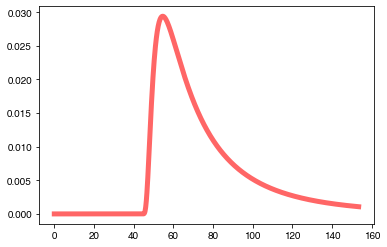

In [17]:
plt.plot(icdx, stats.invgauss.pdf(x = icdx, mu =1, loc = icdmean, scale = icdstd),'r-', lw=5, alpha=0.6, label='norm pdf')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.0, 'Distribution of package W:H ratio per section')

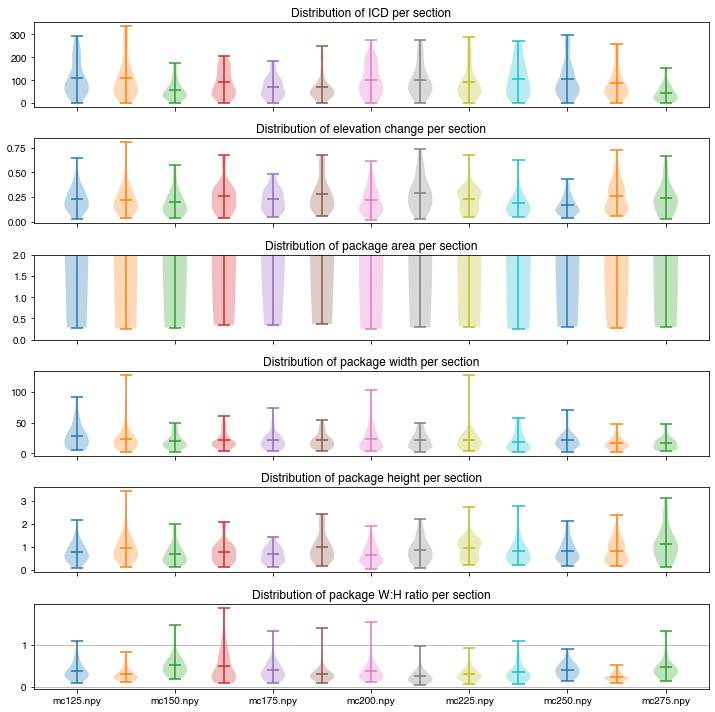

In [18]:
fig, ax = plt.subplots(6, 1, tight_layout = True, figsize = (10,10), sharex = True)

axes = plt.gca()
axes.yaxis.grid()
for loc in range (0, len(onlyfiles)):
    v1 = ax[0].violinplot(datamaster[onlyfiles[loc]][:, 10], [loc], vert = True, showmeans = True)
    v2 = ax[1].violinplot(datamaster[onlyfiles[loc]][:, 13], [loc], vert = True, showmeans = True)
    v3 = ax[2].violinplot(datamaster[onlyfiles[loc]][:, 3], [loc], vert = True, showmeans = True)
    v4 = ax[3].violinplot(datamaster[onlyfiles[loc]][:, 8], [loc], vert = True, showmeans = True)
    v5 = ax[4].violinplot(datamaster[onlyfiles[loc]][:, 9], [loc], vert = True, showmeans = True)
    v6 = ax[5].violinplot(datamaster[onlyfiles[loc]][:, 14], [loc], vert = True, showmeans = True)
   
    #sns.violinplot(x = onlyfiles, y = "ICD",  data = datamaster[onlyfiles[loc]][:, 10])
#v1['bodies'].set_facecolor('m')   

# set style for the axes
ax[-1].set_xticklabels(onlyfiles)
ax[2].set_ylim(0, 2)
ax[0].set_title('Distribution of ICD per section')
ax[1].set_title('Distribution of elevation change per section')
ax[2].set_title('Distribution of package area per section')
ax[3].set_title('Distribution of package width per section')
ax[4].set_title('Distribution of package height per section')
ax[5].set_title('Distribution of package W:H ratio per section')



In [19]:
kwargs = dict(histtype='stepfilled', density = True, edgecolor = 'k', alpha=0.5, bins=50)
#print(distances['c373'])#.values())

In [20]:
#just a check to make sure values not crazy
for key in datamaster:
    print(key, datamaster[key][:, 10].max())

mc100.npy 292.284155164837
mc125.npy 336.50087410192623
mc150.npy 173.4625716331072
mc175.npy 207.44293112591498
mc200.npy 184.7431707251743
mc225.npy 250.6760184399671
mc250.npy 273.85708855841
mc275.npy 274.86670316088725
mc300.npy 288.0406208480493
mc325.npy 269.9588461791443
mc350.npy 298.3596740682338
mc375.npy 259.09007218636805
mc400.npy 153.38145594424287


Text(0.5, 1.0, 'PDF for ICD')

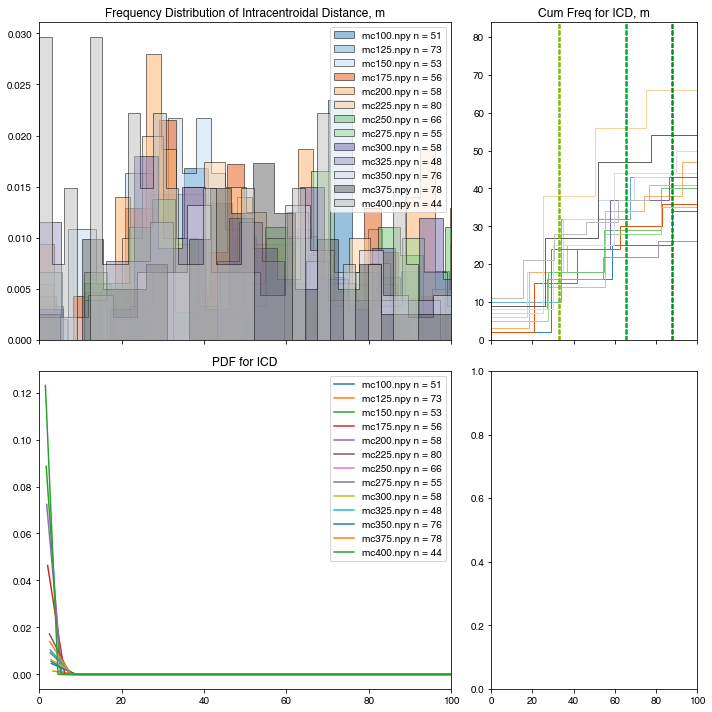

In [21]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10), gridspec_kw={'width_ratios': [2,1]}, tight_layout = True, sharex = True)
for i in onlyfiles:
    ns = len(distances[i])
    textstr = i + ' n = '+str(ns)
    (n, bins, patches) = ax[0, 0].hist(distances[i], **kwargs, label = textstr, color=cpick.to_rgba(onlyfiles.index(i)))
    
    
    ptiles = np.percentile(datamaster[key][:, 10], [50, 75, 90])

    #mode = ax[axloc].axhline(mode_temp[0], lw = 1.2, ls = '--', c = 'xkcd:silver', label = 'Mode')
    #mean = ax[axloc].axhline(mean_temp, lw = 1.2, ls = '--', c = 'xkcd:slate', label = 'Mean (Arith)')
    #median = ax[axloc].axhline(median_temp, lw = 1.2, ls = '--', c = 'xkcd:grey', label = 'Median')
    ptile50 = ax[0, 1].axvline(ptiles[0], lw = 1.2, ls = '--', c = 'xkcd:dark lime green', label = '50th Percentile')
    ptile75 = ax[0, 1].axvline(ptiles[1], lw = 1.2, ls = '--', c = 'xkcd:kelly green', label = '75th Percentile')
    ptile90 = ax[0, 1].axvline(ptiles[2], lw = 1.2, ls = '--', c = 'xkcd:emerald green', label = '90th Percentile')
    

    
    # Compute the PDF on the bin centers from scipy distribution object
    bin_centres = 0.5*(bins[1:] + bins[:-1])
    pdf = st.norm.pdf(bin_centres)
    
    ax[1, 0].plot(bin_centres, pdf, label = textstr)
    cumfreq = ax[0, 1].hist(distances[i], histtype = 'step', cumulative = True, label = textstr, color=cpick.to_rgba(onlyfiles.index(i)))
    
    
#ax.hist(distances['c373'], **kwargs, label = 'c373')
#ax.hist(distances['c256v'], **kwargs, label = 'c256')
#ax.hist(distances['c265v'], **kwargs, label = 'c265')
ax[0,0].legend()
ax[0,0].set_xlim(0,100)
ax[1,0].legend()
ax[0,0].set_title('Frequency Distribution of Intracentroidal Distance, m')

#leg = ax[0, 1].legend(bbox_to_anchor=(1.1, 0.55))

ax[0, 1].set_title('Cum Freq for ICD, m')
ax[1,0].set_title('PDF for ICD')

KeyError: 'mc200'

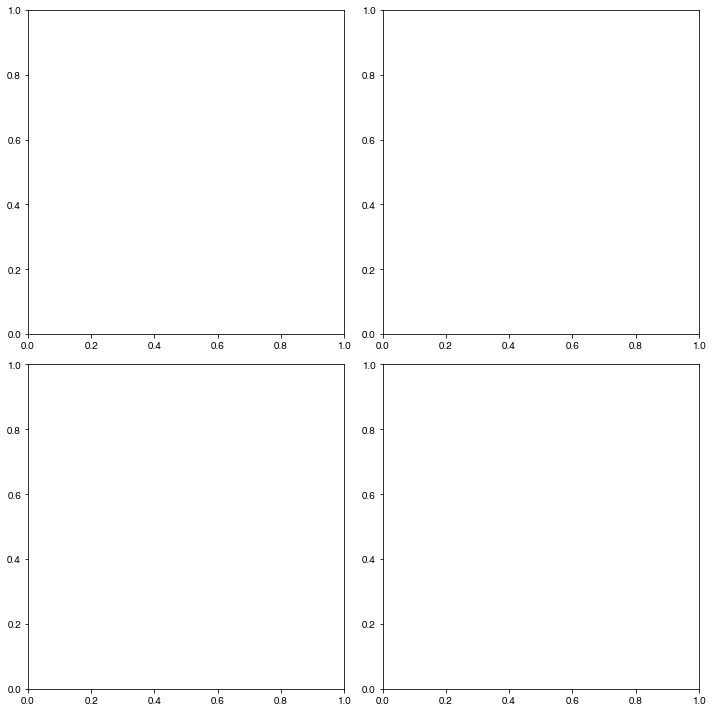

In [22]:
loc = 'mc200'

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10), tight_layout = True)
#xy = c893[:, 12]/c893[:, 13] #because python cannot deal with infs

#posinf = np.where(np.isinf(xy))
#xy[posinf] = 1000

ax1.scatter(datamaster[loc][:, 12], datamaster[loc][:, 13])
ax1.set_xlabel('proportional change in x pos, $\Delta^*_x$')
ax1.set_ylabel('proportional change in y pos, $\Delta^*_y$')

#ax[0, 1].scatter(c893[:, 10], (c893[:, 12]/c893[:, 13]))
ax2.scatter(datamaster[loc][:, 10], (datamaster[loc][:, 12]/datamaster[loc][:,13])) ##make time series of centroid position
ax2.set_xlabel('IC Distance (m)')
ax2.set_ylabel('$\Delta^*_x$\ $ \Delta^*_y$')
                    
histos = ax3.hist2d(datamaster[loc][:, 12], datamaster[loc][:,13], cmap = depths, bins = 50)
ax3.set_xlabel('proportional change in x pos, $\Delta^*_x$')
ax3.set_ylabel('proportional change in y pos, $\Delta^*_y$')

ax4.scatter(datamaster[loc][:, 12], datamaster[loc][:, 10])
ax4.set_ylabel('proportional change in y pos, $\Delta^*_y$')

print(datamaster[loc][:, 13].max())
ax1.set_xlim(-1, 1)
#ax3.set_ylim(-10, 10)
fig.colorbar(histos[3], ax = ax3)

In [ ]:
fig, ax = plt.subplots(1, len(onlyfiles), figsize = (25, 5), tight_layout = True)#, sharex = True, sharey = True)

#ax[0,0].set_xlim(-1, 1)
for key in datamaster:
    #ds = indices[i]
    #print(keynames[i])
    #dsx = ds[:, 12]
    #print(dsx.shape)
    #dsy = ds[:, 13]
    axloc = list(datamaster).index(key)
    ax[axloc].hist2d(datamaster[key][:, 12], datamaster[key][:,13], cmap = depths, bins = 50)
    ax[axloc].set_title(key)
    ax[axloc].set_xlabel('proportional change in x pos, $\Delta^*_x$')
    ax[axloc].set_ylabel('proportional change in y pos, $\Delta^*_y$')
    
#ax[6].set_xlim(-1, 1)

In [ ]:
## time series of centroid distances 
fig, ax = plt.subplots(len(onlyfiles), figsize = (15, 15), tight_layout = True, sharex = True, sharey = True)
for key in datamaster:
    axloc = list(datamaster).index(key)
    
    icdnorm = plt.Normalize(datamaster[key][:, 10].min(), datamaster[key][:, 10].max())
    ax[axloc].scatter(datamaster[key][:, 0], datamaster[key][:, 10], c = datamaster[key][:, 10], cmap=plt.get_cmap('binary')) 
    ax[axloc].set_title(key)
    ax[axloc].set_ylabel('ICD, m')
    
    
    mode_temp = st.mode(datamaster[key][:, 10], nan_policy = 'raise')
    mean_temp = st.tmean(datamaster[key][:, 10], (0,100)) 
    median_temp = np.median(datamaster[key][:, 10])
    
    
    ptiles = np.percentile(datamaster[key][:, 10], [50, 75, 90])

    mode = ax[axloc].axhline(mode_temp[0], lw = 1.2, ls = '--', c = 'xkcd:silver', label = 'Mode')
    mean = ax[axloc].axhline(mean_temp, lw = 1.2, ls = '--', c = 'xkcd:slate', label = 'Mean (Arith)')
    median = ax[axloc].axhline(median_temp, lw = 1.2, ls = '--', c = 'xkcd:grey', label = 'Median')
    ptile50 = ax[axloc].axhline(ptiles[0], lw = 1.2, ls = '--', c = 'xkcd:dark lime green', label = '50th Percentile')
    ptile75 = ax[axloc].axhline(ptiles[1], lw = 1.2, ls = '--', c = 'xkcd:kelly green', label = '75th Percentile')
    ptile90 = ax[axloc].axhline(ptiles[2], lw = 1.2, ls = '--', c = 'xkcd:emerald green', label = '90th Percentile')
    
fig.legend(bbox_to_anchor=(1.1, 0.55), handles = [mode, median, mean, ptile50, ptile75, ptile90])#, loc = 'center right')
ax[-1].set_xlabel('Model Run Time (10s of min)')
ax[0].set_ylim(0, 100)
    

## time series of centroid distances 
fig, ax = plt.subplots(1, len(onlyfiles), figsize = (15, 15), tight_layout = True, sharex = True, sharey = True)
for key in datamaster:
    axloc = list(datamaster).index(key)
    
    icdnorm = plt.Normalize(datamaster[key][:, 0].min(), datamaster[key][:, 0].max())
    ax[axloc].scatter(datamaster[key][:, 10], datamaster[key][:, 0], c = datamaster[key][:, 10], cmap=plt.get_cmap('binary')) 
    ax[axloc].set_title(key)
    
    
    mode_temp = st.mode(datamaster[key][:, 0], nan_policy = 'raise')
    mean_temp = st.tmean(datamaster[key][:, 0], (0,100)) 
    median_temp = np.median(datamaster[key][:, 0])
    
    
    ptiles = np.percentile(datamaster[key][:, 0], [50, 75, 90])

    mode = ax[axloc].axvline(mode_temp[0], lw = 1.2, ls = '--', c = 'xkcd:silver', label = 'Mode')
    mean = ax[axloc].axvline(mean_temp, lw = 1.2, ls = '--', c = 'xkcd:slate', label = 'Mean (Arith)')
    median = ax[axloc].axvline(median_temp, lw = 1.2, ls = '--', c = 'xkcd:grey', label = 'Median')
    ptile50 = ax[axloc].axvline(ptiles[0], lw = 1.2, ls = '--', c = 'xkcd:dark lime green', label = '50th Percentile')
    ptile75 = ax[axloc].axvline(ptiles[1], lw = 1.2, ls = '--', c = 'xkcd:kelly green', label = '75th Percentile')
    ptile90 = ax[axloc].axvline(ptiles[2], lw = 1.2, ls = '--', c = 'xkcd:emerald green', label = '90th Percentile')
    
fig.legend(bbox_to_anchor=(1.1, 0.55), handles = [mode, median, mean, ptile50, ptile75, ptile90])#, loc = 'center right')
ax[0].set_ylabel('Model Run Time (10s of min)')
ax[0].set_xlabel('ICD, m')

#ax[0].set_ylim(0, 100)
    

In [ ]:
#data = (c256, c265, c373, c430, c632, c710, c893)
for key in datamaster:
    nanloc = np.where(np.isnan(datamaster[key][:, :]))
    if nanloc != []:
        #print(nanloc)
        #print(key +' has NaNs')
        datamaster[key][nanloc] = 0

In [ ]:
size = 100
x = scipy.arange(size)
y = scipy.int_(scipy.round_(scipy.st.vonmises.rvs(5,size=size)*47))
dat = datamaster['c400'][:, 10]
h = plt.hist(datamaster['c300'][:, 10], bins = 50, edgecolor = 'k', alpha =0.5)

#dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto']
dist_names = ['norm', 'beta', 'invgauss', 'uniform' ,'gamma', 
              'expon', 'lognorm']
for dist_name in dist_names:
    dist = getattr(scipy.st, dist_name)
    param = dist.fit(dat) #fit() adjusts the weight to the data so that the distribution fits better to the data intervals
    print(param)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
    plt.plot(pdf_fitted, label=dist_name)
    #plt.xlim(0,100)
plt.legend(loc='upper right')
plt.show()

In [ ]:

# Create models from data
def best_fit_distribution(data, bins=50, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True) #SA- x = bin edges y - frequency data of histo
    x = (x + np.roll(x, -1))[:-1] / 2.0  #x is an array of the bin centres for the histogram. 

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]
    
    #DISTRIBUTIONS = [st.norm, st.beta, st.invgauss, st.uniform, st.gamma, st.expon]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf 

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data) #fit() adjusts the weight to the data so that the distribution fits better to the data intervals 

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)  #SA- calculate the pdf for the dist
                sse = np.sum(np.power(y - pdf, 2.0)) #SA- I think this is the sum of the square of the deff between the pdf and the histogram

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax) #basically if you add the ax argument, add the pdf curve to plot
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [ ]:
mpl.rcParams['figure.figsize'] = (16.0, 24.0)
#mpl.style.use('ggplot')

fig, ax = plt.subplots(len(onlyfiles), 2, sharex = True, sharey = True, tight_layout=True)

for key in onlyfiles:
    axloc = list(datamaster).index(key) #integer for ax location of subplot
    print(axloc)
    data = pd.Series(datamaster[key][:, 15].ravel()) ## import distance data from each key (section)
    
    #ax[axloc, 0] = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
    ax[axloc, 0].hist(data, bins = 50, density = True, alpha = 0.5, color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
    # Save plot limits
    dataYLim = ax[axloc, 0].get_ylim()
    
    # Find best fit distribution
    best_fit_name, best_fit_params = best_fit_distribution(data, 50, ax[axloc, 0])
    best_dist = getattr(st, best_fit_name)
    
    
    # Update plots
    ax[axloc, 0].set_ylim(dataYLim)
    #ax[axloc, 0].set_title(u'ICD, m\n All Fitted Distributions')
    #ax[axloc, 0].set_xlabel(u'ICD, m')
    ax[axloc, 0].set_ylabel('Frequency')

    # Make PDF with best params 
    pdf = make_pdf(best_dist, best_fit_params)

    # Display
#plt.figure(figsize=(12,8))
    #ax[axloc, 1] = pdf.plot(lw=2, label='PDF', legend=True)
    pdfline = ax[axloc, 1].plot(pdf, lw = 2, label = 'PDF')
    datahist = ax[axloc, 1].hist(data, bins = 50, density = True, alpha = 0.5, label = 'Data') #, ax = ax[axloc, 1])
    #data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax[axloc, 1])

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)

    ax[axloc, 1].set_title('best fit' + key+ ' ' + dist_str)
   
    ax[axloc, 1].set_ylabel('Frequency')
#fig.legend(handles = [pdfline, datahist])
ax[0,0].set_ylim(0, 0.08)
ttl = fig.suptitle(u'Data Distributions for Intercentroidal Distances (m)')
ttl.set_position([0.5, 1.01])
ax[0, 0].set_title('All fitted distributions')

ax[-1, 0].set_xlabel('ICD, m')
ax[-1, 1].set_xlabel('IC Distance, m')

mpl.rcParams['figure.figsize'] = (16.0, 12.0)
mpl.style.use('ggplot')

# Load data from statsmodels datasets
#data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
data = pd.Series(datamaster['c300'][:, 10]) #may need to ravel if multiple datasets


# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 50, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'c300' + dist_str)
ax.set_xlabel(u'IC Distance, m')
ax.set_ylabel('Frequency')

mpl.rcParams['figure.figsize'] = (16.0, 12.0)
mpl.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = stats.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

In [ ]:
testx = np.array([0.5, 1.5, 2.5, 3.5, 3.5, 4.5, 4.5, 4.5, 4.5])
print(testx)
textx = (testx + np.roll(testx, -1))[:-1] / 2.0
print(textx)

#[:-1] / 2.0

test, testbins = np.histogram(testx, bins = 4)
print('bins', testbins)

testbinsroll = (testbins + np.roll(testbins, -1))[:-1]/2.0
print('bin cent', testbinsroll)

print('hist vals', test)

## Testing to see if the data is random

age, cent x (1), cent y (2), cent area (3), pol minx (4), pol miny (5), pol maxx (6), pol maxy (7), pol width (8), pol height (9), distance (10), reltime (11), delx (12), dely (13)